In [1]:
import os
import sys
from collections import defaultdict
from pathlib import Path
from typing import Dict, List
from zipfile import ZipFile

import IPython
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from scipy import stats
from sklearn.preprocessing import RobustScaler

notebook_path = Path(IPython.extract_module_locals()[1]["__vsc_ipynb_file__"])
project_dir = notebook_path.parent.parent
sys.path.append(str(project_dir))
import src.utils.custom_log as custom_log
import src.utils.json_util as json_util
from src.utils.Csv import Csv
from src.utils.set_rcparams import set_rcparams

os.chdir(project_dir)
LOG = custom_log.init_logger(__name__)
custom_log.set_level(custom_log.LEVELS.DEBUG)
LOG.info("Log initialized")

2024-04-05 20:50:39,114 MainProcess - MainThread INFO Log initialized || 849580755.py


In [2]:
DATA_DIR = Path(r"data\FARS_Data_Raw")

In [3]:
set_rcparams()
PIC_DIR = Path("reports/figures/FARS") / notebook_path.stem
PIC_DIR.mkdir(parents=True, exist_ok=True)
PAGE_WIDTH = 448.13095 / 72

2024-04-05 20:50:39,166 MainProcess - MainThread DEBUG Installed font ['TeX Gyre Adventor', 'TeX Gyre Bonum', 'TeX Gyre Chorus', 'TeX Gyre Cursor', 'TeX Gyre Heros', 'TeX Gyre Heros Cn', 'TeX Gyre Pagella', 'TeX Gyre Schola', 'TeX Gyre Termes'] || set_rcparams.py
2024-04-05 20:50:39,173 MainProcess - MainThread DEBUG Using style src\visualization\dissertation.mplstyle || set_rcparams.py


In [4]:
TRACK_NAMES = ["f", "fm", "m", "mr", "r"]

In [5]:
DUMMY_SIZES = {"HEIGHT":[151.1, 175.3, 186.9], "WEIGHT":[47.3, 77.3, 102.3]}
DUMMY_SIZES["BMI"] = [DUMMY_SIZES["WEIGHT"][i]/((DUMMY_SIZES["HEIGHT"][i]/100)**2) for i in range(3)]
DUMMY_SIZES

{'HEIGHT': [151.1, 175.3, 186.9],
 'WEIGHT': [47.3, 77.3, 102.3],
 'BMI': [20.717255020649368, 25.154498408563068, 29.285795873708654]}

In [6]:
def get_data() -> pd.DataFrame:
    # pre define filter
    rel_cols = {
        "SEAT": [
            "CASEID",
            "PSU",
            "CASENO",
            "CASENUMBER",
            "CATEGORY",
            "VEHNO",
            "SEATLOC",
            "SEATTYPE",
            "ORIENTATION",
            "TRACK",
        ],
        "OCC": [
            "CASEID",
            "PSU",
            "CASENO",
            "CASENUMBER",
            "CATEGORY",
            "VEHNO",
            "OCCNO",
            "SEATLOC",
            "AGE",
            "HEIGHT",
            "WEIGHT",
            "SEX",
            "ROLE",
            "POSTURE",
            "BELTUSE",
            "CHILDSEATUSE",
            "PREGNANT",
            "OBESITY",
            "BMI",
        ],
        "GV": [
            "CASEID",
            "PSU",
            "CASENO",
            "CASENUMBER",
            "CATEGORY",
            "VEHNO",
            "MAKE",
            "MODEL",
            "MODELYR",
            "VEHCLASS",
            "BODYTYPE"
        ],
    }

    # read
    dbs: Dict[str, List[pd.DataFrame]] = defaultdict(list)
    for db_name in rel_cols.keys():
        print(db_name)
        for path in DATA_DIR.glob("CISS*.zip"):
            print(path)
            with ZipFile(path) as archive:
                files = {
                    file.filename.split(".")[0]: file.filename
                    for file in archive.filelist
                }

                with archive.open(files[db_name]) as file:
                    dbs[db_name].append(pd.read_csv(file, usecols=rel_cols[db_name]))
                    if db_name == "SEAT":
                        dbs[db_name][-1] = dbs[db_name][-1].dropna()
        dbs[db_name] = pd.concat(dbs[db_name])

    # merge
    full: pd.DataFrame = dbs["OCC"].merge(
        dbs["SEAT"],
        on=["CASEID", "CASENO", "CASENUMBER", "CATEGORY", "PSU", "SEATLOC", "VEHNO"],
    )

    full = full.merge(dbs["GV"],on=["CASEID", "CASENO", "CASENUMBER", "CATEGORY", "PSU", "VEHNO"],)
    return full


DATA_CISS = get_data()
display(DATA_CISS)

SEAT
data\FARS_Data_Raw\CISS_2017_CSV_FILES.zip
data\FARS_Data_Raw\CISS_2018_CSV_files.zip
data\FARS_Data_Raw\CISS_2019_CSV_files.zip
data\FARS_Data_Raw\CISS_2020_CSV_files.zip
data\FARS_Data_Raw\CISS_2021_CSV_files.zip
OCC
data\FARS_Data_Raw\CISS_2017_CSV_FILES.zip
data\FARS_Data_Raw\CISS_2018_CSV_files.zip
data\FARS_Data_Raw\CISS_2019_CSV_files.zip
data\FARS_Data_Raw\CISS_2020_CSV_files.zip
data\FARS_Data_Raw\CISS_2021_CSV_files.zip
GV
data\FARS_Data_Raw\CISS_2017_CSV_FILES.zip
data\FARS_Data_Raw\CISS_2018_CSV_files.zip
data\FARS_Data_Raw\CISS_2019_CSV_files.zip
data\FARS_Data_Raw\CISS_2020_CSV_files.zip
data\FARS_Data_Raw\CISS_2021_CSV_files.zip


,CASEID,PSU,CASENO,CASENUMBER,CATEGORY,VEHNO,OCCNO,SEATLOC,AGE,HEIGHT,...,OBESITY,BMI,SEATTYPE,ORIENTATION,TRACK,MAKE,MODEL,MODELYR,BODYTYPE,VEHCLASS
0,6035,23,1,1-23-2017-001-04,4,1,1,11,77,168,...,NaN,30.8,1.0,1.0,3.0,55,35,2014,4,3
1,6045,17,1,1-17-2017-001-10,10,1,1,11,42,999,...,NaN,99.9,1.0,1.0,2.0,12,13,1998,4,1
2,6045,17,1,1-17-2017-001-10,10,1,2,13,37,999,...,NaN,99.9,1.0,1.0,2.0,12,13,1998,4,1
3,6042,32,1,1-32-2017-001-09,9,1,1,11,25,160,...,1.0,40.6,1.0,1.0,4.0,54,421,2002,15,15
4,6050,13,1,1-13-2017-001-04,4,1,1,11,36,175,...,NaN,29.7,1.0,1.0,6.0,19,18,2016,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29132,21387,22,41,1-22-2021-041-06,6,1,1,11,56,999,...,NaN,99.9,2.0,1.0,5.0,37,31,2012,2,2
29133,22787,15,97,1-15-2021-097-06,6,1,1,11,22,999,...,NaN,99.9,1.0,1.0,9.0,42,42,2013,4,3
29134,23897,29,92,1-29-2021-092-07,7,2,1,11,39,999,...,NaN,99.9,1.0,1.0,5.0,63,402,2012,14,14
29135,23437,26,136,1-26-2021-136-06,6,1,1,11,23,180,...,NaN,23.8,99.0,9.0,9.0,59,34,1999,4,4


In [7]:
def filter_data(db: pd.DataFrame) -> pd.DataFrame:
    db_rel = []
    for cid in db["CASEID"].unique():
        filt = db[db["CASEID"].eq(cid)].copy()

        filt = filt[filt["AGE"].ge(18)] # anly adult occupants
        filt = filt[filt["TRACK"].between(2,6)] # only adjustable seats in known length position
        filt = filt[filt["SEATLOC"].eq(11) | filt["SEATLOC"].eq(13)] # only seats front-left and front-right
        filt = filt[filt["POSTURE"].eq(0)] # only normal posture
        filt = filt[filt["MODEL"].between(1,397)] # only passenger vehicles
        filt = filt[filt["SEX"].isin([1,2]) | filt["PREGNANT"].eq(0)] # only not pregnant

        # passenger must be in vehicle too
        #for veh in filt["VEHNO"].unique():
        #    filt2 = filt[filt["VEHNO"].eq(veh)]
        #    if 1 in set(filt2["ROLE"]) and 2 in set(filt2["ROLE"]):
        #        db_rel.append(filt2.copy())
        db_rel.append(filt)

    db_rel = pd.concat(db_rel).set_index(
        ["CASEID", "PSU", "CASENO", "CASENUMBER", "CATEGORY", "VEHNO", "OCCNO"]
    )

    db_rel["ROLE"] = db_rel["ROLE"].replace({1:"Driver", 2:"Passenger"})
    db_rel["TRACK"] = db_rel["TRACK"].replace({i:track_name for i, track_name in enumerate(TRACK_NAMES, 2)})
    db_rel["YEAR"] = [int(x.split("-")[2]) for x in db_rel.index.get_level_values("CASENUMBER")]

    return db_rel

DATA_CISS_FILTERED = filter_data(db=DATA_CISS)
display(DATA_CISS_FILTERED)

SEATLOC  AGE  HEIGHT  \
CASEID PSU CASENO CASENUMBER       CATEGORY VEHNO OCCNO                         
6035   23  1      1-23-2017-001-04 4        1     1           11   77     168   
6050   13  1      1-13-2017-001-04 4        1     1           11   36     175   
                                            2     1           11   63     183   
6054   20  1      1-20-2017-001-10 10       1     1           11   27     170   
6068   19  1      1-19-2017-001-06 6        1     1           11   86     157   
...                                                          ...  ...     ...   
23866  24  167    1-24-2021-167-04 4        2     1           11   57     165   
23126  20  117    1-20-2021-117-04 4        1     1           11   20     188   
21176  48  20     1-48-2021-020-07 7        2     1           11   19     157   
23924  19  169    1-19-2021-169-04 4        1     1           11   38     173   
21413  52  55     1-52-2021-055-07 7        2     1           11   18     165   

                                                         WEIGHT  SEX    ROLE  \
CASEID PSU CASENO CASENUMBER       CATEGORY VEHNO OCCNO                        
6035   23  1      1-23-2017-001-04 4        1     1          87    1  Driver   
6050   13  1      1-13-2017-001-04 4        1     1          91    1  Driver   
                                            2     1          88    1  Driver   
6054   20  1      1-20-2017-001-10 10       1     1          86    1  Driver   
6068   19  1      1-19-2017-001-06 6        1     1          59    2  Driver   
...                                                         ...  ...     ...   
23866  24  167    1-24-2021-167-04 4        2     1          59    2  Driver   
23126  20  117    1-20-2021-117-04 4        1     1          95    1  Driver   
21176  48  20     1-48-2021-020-07 7        2     1          50    2  Driver   
23924  19  169    1-19-2021-169-04 4        1     1          68    1  Driver   
21413  52  55     1-52-2021-055-07 7        2     1          48    2  Driver   

                                                         POSTURE  BELTUSE  \
CASEID PSU CASENO CASENUMBER       CATEGORY VEHNO OCCNO                     
6035   23  1      1-23-2017-001-04 4        1     1            0        4   
6050   13  1      1-13-2017-001-04 4        1     1            0        4   
                                            2     1            0        4   
6054   20  1      1-20-2017-001-10 10       1     1            0        4   
6068   19  1      1-19-2017-001-06 6        1     1            0        4   
...                                                          ...      ...   
23866  24  167    1-24-2021-167-04 4        2     1            0        4   
23126  20  117    1-20-2021-117-04 4        1     1            0        4   
21176  48  20     1-48-2021-020-07 7        2     1            0        4   
23924  19  169    1-19-2021-169-04 4        1     1            0        0   
21413  52  55     1-52-2021-055-07 7        2     1            0        4   

                                                         CHILDSEATUSE  \
CASEID PSU CASENO CASENUMBER       CATEGORY VEHNO OCCNO                 
6035   23  1      1-23-2017-001-04 4        1     1                 0   
6050   13  1      1-13-2017-001-04 4        1     1                 0   
                                            2     1                 0   
6054   20  1      1-20-2017-001-10 10       1     1                 0   
6068   19  1      1-19-2017-001-06 6        1     1                 0   
...                                                               ...   
23866  24  167    1-24-2021-167-04 4        2     1                 0   
23126  20  117    1-20-2021-117-04 4        1     1                 0   
21176  48  20     1-48-2021-020-07 7        2     1                 0   
23924  19  169    1-19-2021-169-04 4        1     1                 0   
21413  52  55     1-52-2021-055-07 7        2     1                 0   

          

In [8]:
DATA_CISS_FILTERED.describe()

,SEATLOC,AGE,HEIGHT,WEIGHT,SEX,POSTURE,BELTUSE,CHILDSEATUSE,PREGNANT,OBESITY,BMI,SEATTYPE,ORIENTATION,MAKE,MODEL,MODELYR,BODYTYPE,VEHCLASS,YEAR
count,4233.000000,4233.000000,4233.000000,4233.000000,4233.000000,4233.0,4233.000000,4233.0,2392.0,2392.000000,4233.000000,4233.000000,4233.0,4233.000000,4233.000000,4233.000000,4233.000000,4233.000000,4233.000000
mean,11.369005,42.072762,184.055752,103.610206,1.555398,0.0,3.762580,0.0,0.0,0.340301,29.803000,1.127333,1.0,33.464446,32.927002,2011.494685,4.162060,3.172455,2018.501772
std,0.775879,40.672686,109.212691,145.663477,0.496980,0.0,5.656862,0.0,0.0,0.473909,13.260889,0.579332,0.0,16.762765,12.352327,5.789309,0.928292,0.955546,1.204340
min,11.000000,18.000000,122.000000,34.000000,1.000000,0.0,0.000000,0.0,0.0,0.000000,14.200000,1.000000,1.0,2.000000,1.000000,1954.000000,1.000000,1.000000,2017.000000
25%,11.000000,24.000000,163.000000,66.000000,1.000000,0.0,4.000000,0.0,0.0,0.000000,23.500000,1.000000,1.0,20.000000,25.000000,2008.000000,4.000000,3.000000,2018.000000
50%,11.000000,35.000000,169.000000,78.000000,2.000000,0.0,4.000000,0.0,0.0,0.000000,26.800000,1.000000,1.0,35.000000,34.000000,2013.000000,4.000000,3.000000,2018.000000
75%,11.000000,55.000000,178.000000,93.000000,2.000000,0.0,4.000000,0.0,0.0,1.000000,31.600000,1.000000,1.0,49.000000,40.000000,2016.000000,4.000000,4.000000,2019.000000
max,13.000000,999.000000,999.000000,999.000000,2.000000,0.0,99.000000,0.0,0.0,1.000000,99.900000,7.000000,1.0,69.000000,58.000000,2021.000000,12.000000,5.000000,2021.000000


In [9]:
def get_overall_population() -> pd.DataFrame:
    name_sets = [
        ["HEIGHTTC_A", "WEIGHTLBTC_A", "AGEP_A", "SEX_A"],
        ["AHEIGHT", "AWEIGHTP", "AGE_P", "SEX"],
    ]
    end_names = ["HEIGHT", "WEIGHT", "AGE", "SEX"]

    dbs = []
    for path in DATA_DIR.glob("adult*.zip"):
        print(path)
        with ZipFile(path) as archive:
            with archive.open(archive.filelist[0]) as file:
                db = pd.read_csv(file)

        i = 0 if name_sets[0][0] in set(db.columns) else 1
        renamer = {name_sets[i][j]: end_name for j, end_name in enumerate(end_names)}
        db.rename(
            columns=renamer,
            inplace=True,
        )
        db = db[end_names].copy()

        db["HEIGHT"] *= 2.54
        db["WEIGHT"] /= 2.205
        db["BMI"] = db["WEIGHT"] / (db["HEIGHT"] / 100) ** 2
        db["ROLE"] = ["Population US"] * db.shape[0]
        db["YEAR"] = [int(path.stem[5:7]) + 2000] * db.shape[0]

        dbs.append(db.copy())

    dbs = pd.concat(dbs, ignore_index=True)
    return dbs[dbs["WEIGHT"].le(150) & dbs["HEIGHT"].le(210)]


DATA_NHIS = get_overall_population()
DATA_NHIS.describe()

data\FARS_Data_Raw\adult17csv.zip
data\FARS_Data_Raw\adult18csv.zip
data\FARS_Data_Raw\adult19csv.zip
data\FARS_Data_Raw\adult20csv.zip
data\FARS_Data_Raw\adult21csv.zip


,HEIGHT,WEIGHT,AGE,SEX,BMI,YEAR
count,132242.000000,132242.000000,132242.000000,132242.000000,132242.000000,132242.000000
mean,169.568135,80.137524,52.307066,1.536683,27.798268,2019.082304
std,9.894658,17.849785,18.393491,0.498654,5.477747,1.389846
min,149.860000,45.351474,18.000000,1.000000,14.764740,2017.000000
25%,162.560000,66.666667,37.000000,1.000000,23.744064,2018.000000
50%,170.180000,78.458050,53.000000,2.000000,27.041583,2019.000000
75%,177.800000,90.702948,67.000000,2.000000,31.005953,2020.000000
max,193.040000,135.600907,99.000000,2.000000,53.917682,2021.000000


In [10]:
def save_fig(fig, fig_name:str):
    for suffix in ["png", "pdf"]:
        suffix_dir = PIC_DIR / suffix.upper()
        suffix_dir.mkdir(parents=True, exist_ok=True)
        fig.savefig(suffix_dir / f"{fig_name}.{suffix}")

In [ ]:
def plt_counts():
    fig, ax = plt.subplots(figsize=(0.7*PAGE_WIDTH, 0.7*PAGE_WIDTH))
    sns.countplot(data=DATA_CISS_FILTERED, x="TRACK", hue="ROLE", order=TRACK_NAMES, ax=ax);
    print(DATA_CISS_FILTERED[DATA_CISS_FILTERED["ROLE"].eq("Driver")].shape[0], DATA_CISS_FILTERED[DATA_CISS_FILTERED["ROLE"].eq("Passenger")].shape[0])
    save_fig(fig=fig, fig_name="samples_per_track")

plt_counts()

In [ ]:
def plot_combi():
    anthros = ["HEIGHT", "AGE", "WEIGHT", "BMI"]
    fi = DATA_CISS_FILTERED.copy()
    for col in anthros:
        idxs = []
        for idx in fi[fi[col].ge(90 if col == "BMI" else 900)].index.droplevel("OCCNO"):
            idxs.extend([list(idx) + [i] for i in (1, 2)])
        fi = fi.loc[~fi.index.isin(idxs)].copy()

    for col in ["HEIGHT", "AGE", "WEIGHT", "BMI"]:
        fig, ax = plt.subplots(ncols=2, figsize=(PAGE_WIDTH, 0.6 * PAGE_WIDTH))

        sns.boxplot(data=fi, x="TRACK", y=col, hue="ROLE", ax=ax[0], order=TRACK_NAMES, boxprops=dict(alpha=0.3))
        sns.stripplot(data=fi, x="TRACK", y=col, hue="ROLE", ax=ax[0], order=TRACK_NAMES, dodge=True, size=1)

        ax[0].grid(axis="y")
        ax[0].set_axisbelow(True)
        ax[0].legend().remove()

        if col in DUMMY_SIZES:

            for size in DUMMY_SIZES[col]:
                ax[0].axhline(size, c="black", ls=":")
                ax[1].axvline(size, c="black", ls=":")


        fi = pd.concat([fi, DATA_NHIS])
        repl = {role: f"{role} (n={fi[fi['ROLE'].eq(role)].shape[0]:,})" for role in ("Driver", "Passenger", "Population US")}
        fi.replace({"ROLE": repl}, inplace=True)


        sns.kdeplot(data=fi, x=col, hue="ROLE", ax=ax[1], palette=sns.color_palette()[:3], common_norm=False, bw_adjust=1.6)
        g = sns.rugplot(data=fi, x=col, hue="ROLE", ax=ax[1], palette=sns.color_palette()[:3])
        g.legend_.set_title(None)
        sns.move_legend(ax[1], "lower center", bbox_to_anchor=(0.5, 1))  # "upper left", bbox_to_anchor=(1, 1))
        ax[1].grid()

        fig.tight_layout()
        save_fig(fig=fig, fig_name=f"boxplots_{col}")

plot_combi()

In [ ]:
def plot_combi_joint():
    anthros = ["HEIGHT", "AGE", "WEIGHT", "BMI"]
    fi = DATA_CISS_FILTERED.copy()
    for col in anthros:
        idxs = []
        for idx in fi[fi[col].ge(90 if col == "BMI" else 900)].index.droplevel("OCCNO"):
            idxs.extend([list(idx) + [i] for i in (1, 2)])
        fi = fi.loc[~fi.index.isin(idxs)].copy()

    for col in ["HEIGHT", "AGE", "WEIGHT", "BMI"]:
        # fig, ax = plt.subplots(figsize=(PAGE_WIDTH, 0.6 * PAGE_WIDTH), layout="constrained")

        g = sns.JointGrid(marginal_ticks=True)
        g.figure.delaxes(g.ax_marg_x)
        g.figure.set_figheight(0.6 * PAGE_WIDTH)
        g.figure.set_figwidth(PAGE_WIDTH)

        sns.boxplot(data=fi, x="TRACK", y=col, hue="ROLE", ax=g.ax_joint, order=TRACK_NAMES, boxprops=dict(alpha=0.3))
        sns.stripplot(data=fi, x="TRACK", y=col, hue="ROLE", ax=g.ax_joint, order=TRACK_NAMES, dodge=True, size=1)

        if col in DUMMY_SIZES:
            for size in DUMMY_SIZES[col]:
                g.ax_joint.axhline(size, c="black", ls=":")
                g.ax_marg_y.axhline(size, c="black", ls=":")


        fi = pd.concat([fi, DATA_NHIS])
        repl = {role: f"{role}\n(n={fi[fi['ROLE'].eq(role)].shape[0]:,})" for role in ("Driver", "Passenger", "Population US")}
        fi.replace({"ROLE": repl}, inplace=True)

        sns.kdeplot(data=fi, y=col, hue="ROLE", ax=g.ax_marg_y, palette=sns.color_palette()[:3], common_norm=False, bw_adjust=1.6)
        sns.rugplot(data=fi, y=col, hue="ROLE", ax=g.ax_marg_y, palette=sns.color_palette()[:3])

        # format
        g.ax_joint.get_legend().remove()
        g.ax_joint.grid(axis="y")
        g.ax_joint.set_axisbelow(True)
        
        g.ax_marg_y.legend_.set_title(None)

        #fig.tight_layout()
        #save_fig(fig=fig, fig_name=f"boxplots_{col}")

plot_combi_joint()

c:\Temp\ipykernel_10468\2641749927.py:5: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.savefig(suffix_dir / f"{fig_name}.{suffix}")
c:\Users\plaschkies\Documents\Py_Projects\aihiii\.conda\Lib\site-packages\IPython\core\events.py:93: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  func(*args, **kwargs)
c:\Users\plaschkies\Documents\Py_Projects\aihiii\.conda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


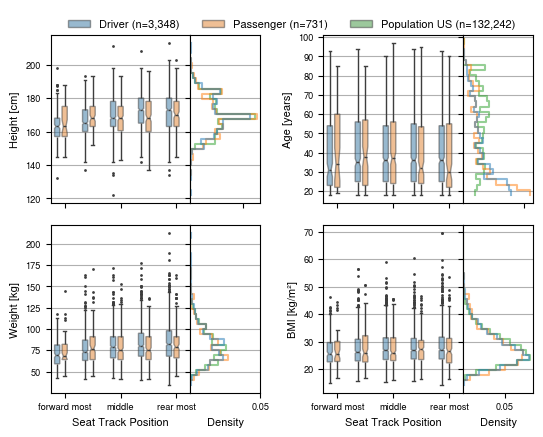

In [22]:
import matplotlib.gridspec as gridspec


def plot_combi_joint_onepage():
    anthros = ["HEIGHT", "AGE", "WEIGHT", "BMI"]
    anthros_mosaic = [["HEIGHT", "AGE"], ["WEIGHT", "BMI"]]
    fi = DATA_CISS_FILTERED.copy()
    for col in anthros:
        idxs = []
        for idx in fi[fi[col].ge(90 if col == "BMI" else 900)].index.droplevel("OCCNO"):
            idxs.extend([list(idx) + [i] for i in (1, 2)])
        fi = fi.loc[~fi.index.isin(idxs)].copy()
    fi = pd.concat([fi, DATA_NHIS])
    repl = {role: f"{role} (n={fi[fi['ROLE'].eq(role)].shape[0]:,})" for role in ("Driver", "Passenger", "Population US")}
    fi.replace({"ROLE": repl}, inplace=True)

    fig = plt.figure(layout="constrained", figsize=(PAGE_WIDTH, 0.8 * PAGE_WIDTH))
    gs_root = gridspec.GridSpec(3, 2, figure=fig, height_ratios=(0.02, *([1] * 2)), wspace=0.3)

    gs_legend = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_root[0, :])
    ax_legend = fig.add_subplot(gs_legend[0])

    gs_anthros, ax_anthros = {}, {}
    for i, col in enumerate(anthros_mosaic, 1):
        for j, anthro in enumerate(col):
            gs_anthros[anthro] = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs_root[i, j], width_ratios=(2, 1), wspace=0)
            ax_anthros[anthro] = fig.add_subplot(gs_anthros[anthro][0])
            ax_anthros[f"{anthro}_DENSE"] = fig.add_subplot(gs_anthros[anthro][1])

    for col in anthros:
        # main field
        sns.boxplot(
            data=fi,
            x="TRACK",
            y=col,
            hue="ROLE",
            ax=ax_anthros[col],
            order=TRACK_NAMES,
            boxprops=dict(alpha=0.5),
            gap=0.3,
            fliersize=1,
            notch=True,
        )

        # side field
        sns.histplot(
            data=fi,
            y=col,
            hue="ROLE",
            ax=ax_anthros[f"{col}_DENSE"],
            palette=sns.color_palette()[:3],
            common_norm=False,
            stat="density",
            element="step",
            bins=30,
            fill=False,
            alpha=0.5,
        )

        ax_anthros[col].set_ylabel(
            {"HEIGHT": "Height [cm]", "AGE": "Age [years]", "WEIGHT": "Weight [kg]", "BMI": "BMI [kg/m²]"}[col]
        )

        # format
        ax_anthros[col].grid(axis="y")
        ax_anthros[col].set_xticks([0,2,4])
        ax_anthros[col].set_axisbelow(True)
        ax_anthros[f"{col}_DENSE"].set_ylabel("")
        ax_anthros[f"{col}_DENSE"].set_yticklabels([])
        # ax_anthros[f"{col}_DENSE"].set_xlim([0, 0.09])
        ax_anthros[f"{col}_DENSE"].set_ylim(ax_anthros[col].get_ylim())
        ax_anthros[f"{col}_DENSE"].set_xlabel("")
        # ax_anthros[f"{col}_DENSE"].set_xticklabels([])
        ax_anthros[f"{col}_DENSE"].set_xticks([0.05])
        # ax_anthros[f"{col}_DENSE"].axis("off")
        ax_anthros[f"{col}_DENSE"].grid(axis="y")

        # g.ax_marg_y.legend_.set_title(None)

        # save_fig(fig=fig, fig_name=f"boxplots_{col}")

    handles, labels = ax_anthros["HEIGHT"].get_legend_handles_labels()
    ax_legend.legend(handles[:3], labels[:3], ncols=3, loc="upper center", title="")
    ax_legend.axis("off")
    for col in anthros:
        ax_anthros[col].get_legend().remove()
        ax_anthros[f"{col}_DENSE"].get_legend().remove()

    for col in ["HEIGHT", "AGE"]:
        ax_anthros[col].set_xlabel("")
        ax_anthros[col].set_xticklabels([])
        ax_anthros[f"{col}_DENSE"].set_xticklabels([])
    for col in ["WEIGHT", "BMI"]:
        ax_anthros[col].set_xticklabels(["forward most","middle", "rear most"])
        ax_anthros[col].set_xlabel("Seat Track Position")
    for col in ["WEIGHT_DENSE", "BMI_DENSE"]:
        ax_anthros[col].set_xlabel("Density")

    save_fig(fig=fig, fig_name="boxplots_all")


plot_combi_joint_onepage()

In [ ]:
def plot_combi_2():
    for col in ["HEIGHT", "AGE", "WEIGHT", "BMI"]:
        fig, ax = plt.subplots(ncols=2, figsize=(PAGE_WIDTH, PAGE_WIDTH))

        idxs = []
        for idx in DATA_CISS_FILTERED[
            DATA_CISS_FILTERED[col].ge(90 if col == "BMI" else 900)
        ].index.droplevel("OCCNO"):
            idxs.extend([list(idx) + [i] for i in (1, 2)])
        fi = DATA_CISS_FILTERED.loc[~DATA_CISS_FILTERED.index.isin(idxs)].copy()

        sns.lineplot(
            data=fi.replace({"TRACK": {u: k for k, u in enumerate(TRACK_NAMES)}}),
            x="TRACK",
            y=col,
            hue="ROLE",
            style="ROLE",
            ax=ax[0],
            estimator="median",
            markers=True,
            dashes=False,
            errorbar=("pi", 95),
        )
        ax[0].set_xticks(range(len(TRACK_NAMES)))
        ax[0].set_xticklabels(TRACK_NAMES)
        ax[0].grid()
        ax[0].set_title("Median & 95% Range")

        if col in DUMMY_SIZES:
            for size in DUMMY_SIZES[col]:
                ax[0].axhline(size, c="black", ls=":")
                ax[1].axvline(size, c="black", ls=":")

        fi = pd.concat([fi, DATA_NHIS])
        repl = {
            role: f"{role} (n={fi[fi['ROLE'].eq(role)].shape[0]:,})"
            for role in ("Driver", "Passenger", "Population US")
        }
        fi.replace({"ROLE": repl}, inplace=True)

        sns.kdeplot(
            data=fi,
            x=col,
            hue="ROLE",
            ax=ax[1],
            palette=sns.color_palette()[:3],
            common_norm=False,
            bw_adjust=1.6,
        )
        g = sns.rugplot(
            data=fi, x=col, hue="ROLE", ax=ax[1], palette=sns.color_palette()[:3]
        )
        ax[1].grid()
        ax[1].set_title("Distribution")
        ax[0].set_ylim([fi[col].min(), fi[col].max()])
        ax[1].set_xlim([fi[col].min(), fi[col].max()])
        fig.tight_layout()

plot_combi_2()

In [ ]:
def plot_another():
    fig, ax = plt.subplots(ncols=3, figsize=(15,5), sharex="all", sharey="all")

    idxs = []
    for idx in  DATA_CISS_FILTERED[DATA_CISS_FILTERED["HEIGHT"].ge(900)].index.droplevel("OCCNO"):
        idxs.extend([list(idx) + [i] for i in (1,2)])
    fi = DATA_CISS_FILTERED.loc[~DATA_CISS_FILTERED.index.isin(idxs)].copy()

    for i, role in enumerate(("Driver", "Passenger")):
        fi_2 = fi[fi["ROLE"].eq(role)].copy()
        repl = {track: f"{track} (n={fi_2[fi_2['TRACK'].eq(track)].shape[0]:,})" for track in TRACK_NAMES}
        fi_2.replace({"TRACK":repl}, inplace=True)
        sns.kdeplot(data=fi_2, x="HEIGHT", hue="TRACK", ax=ax[i], hue_order=repl.values(), common_norm=False)
        ax[i].set_title(f"{role} (n={fi_2.shape[0]:,})")
    repl = {track: f"{track} (n={fi[fi['TRACK'].eq(track)].shape[0]:,})" for track in TRACK_NAMES}
    fi.replace({"TRACK":repl}, inplace=True)
    sns.kdeplot(data=fi, x="HEIGHT", hue="TRACK", ax=ax[-1], hue_order=repl.values(), common_norm=False)
    ax[-1].set_title(f"Total (n={fi.shape[0]:,})")

    for i in range(3):
        ax[i].set_xlim([fi["HEIGHT"].min(), fi["HEIGHT"].max()])
        ax[i].grid()
    fig.tight_layout()

plot_another()

In [ ]:
def plot_alot():
    for col in ["HEIGHT", "AGE", "WEIGHT", "BMI"]:
        fig, ax = plt.subplots(ncols=2, figsize=(11, 5))

        idxs = []
        for idx in DATA_CISS_FILTERED[
            DATA_CISS_FILTERED[col].ge(90 if col == "BMI" else 900)
        ].index.droplevel("OCCNO"):
            idxs.extend([list(idx) + [i] for i in (1, 2)])
        fi = DATA_CISS_FILTERED.loc[~DATA_CISS_FILTERED.index.isin(idxs)].copy()
        fi["Role / Sex"] = [
            f"{fi.loc[idx, 'ROLE']} - {fi.loc[idx, 'SEX']}" for idx in fi.index
        ]
        overal_pop_ = DATA_NHIS[DATA_NHIS["SEX"].isin([1, 2])].copy()
        overal_pop_["Role / Sex"] = [
            f"{overal_pop_.loc[idx, 'ROLE']} - {overal_pop_.loc[idx, 'SEX']}"
            for idx in overal_pop_.index
        ]

        order = sorted(fi["Role / Sex"].unique())

        sns.lineplot(
            data=fi.replace({"TRACK": {u: k for k, u in enumerate(TRACK_NAMES)}}),
            x="TRACK",
            y=col,
            hue="Role / Sex",
            style="Role / Sex",
            ax=ax[0],
            estimator="median",
            markers=True,
            dashes=False,
            errorbar=("pi", 95),
            hue_order=order,
        )
        ax[0].set_xticks(range(len(TRACK_NAMES)))
        ax[0].set_xticklabels(TRACK_NAMES)
        ax[0].grid()
        ax[0].set_title("Median & 95% Range")

        fi = pd.concat([fi, overal_pop_])
        repl = {
            role: f"{role} (n={fi[fi['ROLE'].eq(role)].shape[0]:,})"
            for role in ("Driver", "Passenger", "Population US")
        }
        fi.replace({"ROLE": repl}, inplace=True)

        repl = {}
        order_new = []
        for role_sex in sorted(fi["Role / Sex"].unique()):
            rs = role_sex.split(" - ")
            rs = f"{rs[0]} - {'Male' if rs[1] == '1' else 'Female'}"
            cnt = fi[fi["Role / Sex"].eq(role_sex)].shape[0]
            repl[role_sex] = f"{rs} (n={cnt:,})"
            order_new.append(repl[role_sex])

        # repl = {
        #    track: f"{track} (n={fi[fi['Role / Sex'].eq(track)].shape[0]:,})"
        #    for track in fi["Role / Sex"].unique()
        # }
        fi.replace({"Role / Sex": repl}, inplace=True)

        g = sns.kdeplot(
            data=fi,
            x=col,
            hue="Role / Sex",
            hue_order=order_new,
            ax=ax[1],
            palette=sns.color_palette()[:6],
            common_norm=False,
            bw_adjust=1.7,
        )
        if col in DUMMY_SIZES:
            for size in DUMMY_SIZES[col]:
                ax[0].axhline(size, c="black", ls=":")
                ax[1].axvline(size, c="black", ls=":")
        ax[1].grid()
        ax[1].set_title("Distribution")
        ax[0].set_ylim([fi[col].min(), fi[col].max()])
        ax[1].set_xlim([fi[col].min(), fi[col].max()])

        # legend
        #ax[0].get_legend().remove()
        ax[1].get_legend().set_bbox_to_anchor((1, 1))

        fig.tight_layout()
        break

plot_alot()

In [ ]:
def plot_even_more():
    fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(20, 15), sharex="all", sharey="all")

    idxs = []
    for idx in DATA_CISS_FILTERED[DATA_CISS_FILTERED["HEIGHT"].ge(900)].index.droplevel("OCCNO"):
        idxs.extend([list(idx) + [i] for i in (1, 2)])
    fi = DATA_CISS_FILTERED.loc[~DATA_CISS_FILTERED.index.isin(idxs)].copy()

    for j, sex in enumerate((1, 2)):
        for i, role in enumerate(("Driver", "Passenger")):
            fi_2 = fi[fi["ROLE"].eq(role) & fi["SEX"].eq(sex)].copy()
            repl = {
                track: f"{track} (n={fi_2[fi_2['TRACK'].eq(track)].shape[0]:,})"
                for track in TRACK_NAMES
            }
            fi_2.replace({"TRACK": repl}, inplace=True)
            sns.kdeplot(
                data=fi_2,
                x="HEIGHT",
                hue="TRACK",
                ax=ax[j, i],
                hue_order=repl.values(),
                common_norm=False,
            )
            sns.kdeplot(data=fi_2, x="HEIGHT", ax=ax[j, i], color="black")
            ax[j, i].set_title(
                ("Male" if sex == 1 else "Female") + f" {role} (n={fi_2.shape[0]:,})"
            )

        fi_2 = fi[fi["SEX"].eq(sex)].copy()
        repl = {
            track: f"{track} (n={fi_2[fi_2['TRACK'].eq(track)].shape[0]:,})"
            for track in TRACK_NAMES
        }
        fi_2.replace({"TRACK": repl}, inplace=True)
        sns.kdeplot(
            data=fi_2,
            x="HEIGHT",
            hue="TRACK",
            ax=ax[j, -1],
            hue_order=repl.values(),
            common_norm=False,
        )
        sns.kdeplot(data=fi_2, x="HEIGHT", ax=ax[j, -1], color="black")
        ax[j, -1].set_title(f"Total {'Male' if sex==1 else 'Female'} (n={fi_2.shape[0]:,})")

    for i, role in enumerate(("Driver", "Passenger")):
        fi_2 = fi[fi["ROLE"].eq(role)].copy()
        repl = {
            track: f"{track} (n={fi_2[fi_2['TRACK'].eq(track)].shape[0]:,})"
            for track in TRACK_NAMES
        }
        fi_2.replace({"TRACK": repl}, inplace=True)
        sns.kdeplot(
            data=fi_2,
            x="HEIGHT",
            hue="TRACK",
            ax=ax[-1, i],
            hue_order=repl.values(),
            common_norm=False,
        )
        sns.kdeplot(data=fi_2, x="HEIGHT", ax=ax[-1, i], color="black")
        ax[-1, i].set_title(f"Total {role} (n={fi_2.shape[0]:,})")

    repl = {
        track: f"{track} (n={fi[fi['TRACK'].eq(track)].shape[0]:,})"
        for track in TRACK_NAMES
    }
    fi.replace({"TRACK": repl}, inplace=True)
    sns.kdeplot(
        data=fi,
        x="HEIGHT",
        hue="TRACK",
        ax=ax[-1, -1],
        hue_order=repl.values(),
        common_norm=False,
    )
    sns.kdeplot(data=fi, x="HEIGHT", ax=ax[-1, -1], color="black")
    ax[-1, -1].set_title(f"Total Total (n={fi.shape[0]:,})")

    for i in range(3):
        for j in range(3):
            ax[i, j].set_xlim([fi["HEIGHT"].min(), fi["HEIGHT"].max()])
            ax[i, j].grid()
            ax[i, j].set_xticks(np.arange(140, 201, 5))
    fig.tight_layout()

plot_even_more()

In [ ]:
def get_correlations():
    collector = defaultdict(list)
    statis = (
        ("Pearson", stats.pearsonr),
        ("Spearman", stats.spearmanr),
        ("Kendall", stats.kendalltau),
    )
    scaler = RobustScaler()


    for col in ["HEIGHT", "AGE", "WEIGHT", "BMI"]:
        idxs = []
        for idx in DATA_CISS_FILTERED[
            DATA_CISS_FILTERED[col].ge(90 if col == "BMI" else 900)
        ].index.droplevel("OCCNO"):
            idxs.extend([list(idx) + [i] for i in (1, 2)])
        fi = DATA_CISS_FILTERED.loc[~DATA_CISS_FILTERED.index.isin(idxs)].copy()
        fi.replace(
            {"TRACK": {track: i for i, track in enumerate(TRACK_NAMES)}}, inplace=True
        )

        q1 = fi[col].quantile(0.25)
        q3 = fi[col].quantile(0.75)
        iqr = q3-q1
        fi = fi[fi[col].between(q1-1.5*iqr, q3+1.5*iqr)].copy()



        for role in fi["ROLE"].unique():
            for min_track in ((0, 4), (0, 3), (1, 4), (1, 3)):
                fi2 = fi[fi["ROLE"].eq(role) & fi["TRACK"].between(*min_track)]

                tr_data = fi2["TRACK"]
                col_data = fi2[col]
                for stat_name, method in statis:
                    cor = method(tr_data, col_data)

                    collector["Method"].append(stat_name)
                    collector["Correlation"].append(abs(cor.statistic))
                    collector["P-Value"].append(cor.pvalue)
                    collector["Role"].append(role)
                    collector["Measure"].append(col)
                    collector["Count"].append(fi2.shape[0])
                    collector["Min Track"].append(str(min_track))

    collector = pd.DataFrame(collector)
    return collector

CORRELATIONS = get_correlations()

In [ ]:
def plt_correlations():
    fig, ax = plt.subplots(ncols=2, nrows=2, sharex="all", sharey="all", figsize=(7, 7))
    for q, mini in enumerate(sorted(CORRELATIONS["Min Track"].unique())):
        i, j = int(q / 2), q % 2
        fi = CORRELATIONS[CORRELATIONS["Method"].eq("Kendall") & CORRELATIONS["Min Track"].eq(mini)]
        sns.barplot(data=fi, x="Measure", y="Correlation", hue="Role", ax=ax[i, j], alpha=0.8)
        mn = eval(mini)
        ax[i, j].set_title(
            f"Track Positions from {TRACK_NAMES[mn[0]]} to {TRACK_NAMES[mn[1]]}"
        )
        ax[i, j].set_ylim(0, 1)
        ax[i, j].grid(axis="y")
        ax[i, j].set_xlabel("")
        ax[i, j].set_yticks(np.arange(0, 1.01, 0.1))
        ax[i, j].set_axisbelow(True)
        if not (i == 0 and j == 0):
            ax[i, j].get_legend().remove()
    fig.suptitle("Full Data without Outlier")
    fig.tight_layout()

plt_correlations()

In [ ]:
def correlation_median():
    collector_median = defaultdict(list)
    statis = (
        ("Pearson", stats.pearsonr),
        ("Spearman", stats.spearmanr),
        ("Kendall", stats.kendalltau),
    )
    scaler = RobustScaler()


    for col in ["HEIGHT", "AGE", "WEIGHT", "BMI"]:
        idxs = []
        for idx in DATA_CISS_FILTERED[
            DATA_CISS_FILTERED[col].ge(90 if col == "BMI" else 900)
        ].index.droplevel("OCCNO"):
            idxs.extend([list(idx) + [i] for i in (1, 2)])
        fi = DATA_CISS_FILTERED.loc[~DATA_CISS_FILTERED.index.isin(idxs)].copy()
        fi.replace(
            {"TRACK": {track: i for i, track in enumerate(TRACK_NAMES)}}, inplace=True
        )

        for role in fi["ROLE"].unique():
            for min_track in ((0, 4), (0, 3), (1, 4), (1, 3)):
                fi2 = fi[fi["ROLE"].eq(role) & fi["TRACK"].between(*min_track)]

                tmp = fi2[["HEIGHT", "TRACK"]].groupby("TRACK").median()

                tr_data = tmp.index
                col_data = tmp.values.flatten()
                for stat_name, method in statis:
                    cor = method(tr_data, col_data)

                    collector_median["Method"].append(stat_name)
                    collector_median["Correlation"].append(cor.statistic)
                    collector_median["P-Value"].append(cor.pvalue)
                    collector_median["Role"].append(role)
                    collector_median["Measure"].append(col)
                    collector_median["Count"].append(fi2.shape[0])
                    collector_median["Min Track"].append(str(min_track))

    collector_median = pd.DataFrame(collector_median).fillna(0)
    return collector_median

CORRELATION_MEDIAN = correlation_median()

In [ ]:
def plot_cor_median():
    fig, ax = plt.subplots(ncols=2, nrows=2, sharex="all", sharey="all", figsize=(7, 7))
    for q, mini in enumerate(sorted(CORRELATION_MEDIAN["Min Track"].unique())):
        i, j = int(q / 2), q % 2
        fi = CORRELATION_MEDIAN[CORRELATION_MEDIAN["Method"].eq("Kendall") & CORRELATION_MEDIAN["Min Track"].eq(mini)]
        sns.barplot(data=fi, x="Measure", y="Correlation", hue="Role", ax=ax[i, j], alpha=0.8)
        mn = eval(mini)
        ax[i, j].set_title(
            f"Track Positions from {TRACK_NAMES[mn[0]]} to {TRACK_NAMES[mn[1]]}"
        )
        ax[i, j].set_ylim(0, 1)
        ax[i, j].grid(axis="y")
        ax[i, j].set_xlabel("")
        ax[i, j].set_yticks(np.arange(0, 1.01, 0.1))
        ax[i, j].set_axisbelow(True)
        if not (i == 0 and j == 0):
            ax[i, j].get_legend().remove()
    fig.suptitle("Median")
    fig.tight_layout()
plot_cor_median()